In [1]:
import itertools
import json
import numpy as np
import pandas as pd
import random 
import re
import string
import warnings
warnings.simplefilter("ignore")

from collections import Counter
from gensim.models.word2vec import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from konlpy.utils import pprint
from konlpy.tag import Hannanum
hannanum = Hannanum()
from konlpy.tag import Okt
okt = Okt()
from konlpy.tag import Kkma
kkma = Kkma()
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import read_excel
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from tqdm import trange
from wordcloud import WordCloud

from msba import posts as p
from msba import stopwords as stopwords

In [48]:
def interested_words():
    # 핵심단어 읽어 오기
    my_sheet = '소비키워드'
    keywords_filename = 'deskresearch_.xlsx'
    df = read_excel(keywords_filename, sheet_name = my_sheet, header=1) # index_col='번호'
    keywords = df['핵심단어']
    subkeywords = df['대체어']
    interested_words = df['키워드']
    return keywords, subkeywords, interested_words

def oneDArray(x):
    return list(itertools.chain(*x))

def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
#     text = re.sub('[A-z]', '', text)
#     text = re.sub('[0-9]', '', text)
    text = re.sub('[\'\"]', '', text)
    text = re.sub('[\'\n"]', '', text)
    res = ''.join([i for i in text if not i.isdigit()]) 
    return text

def preprocessing_2(rows):
    pattern = re.compile(r"[.,?!★~]")
    sentences = []
    for row in rows:
        sentences = sentences + pattern.split(row.replace("\xa0", "").replace("\t","").strip())
        sentences = list(set(sentences))        
    return sentences

def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

# 실전 : 말뭉치 생성 및 전처리
def preprocessing_3(sentences):
    # Convert list of strings to string
#     full_str = convert_list_to_string(sentences[1])
#     # print(full_str)

    pattern = re.compile(r".*(광고정보).*")

    corpus = []
    for sentence in sentences:
        if len(sentence):
            sentence = sentence.strip().split(" ")
            sentence = convert_list_to_string(sentence).replace("  ", " ").strip()
            if pattern.match(sentence):
                continue
            else:
                corpus.append(sentence)
    return corpus

def preprocessing_4(docs):
    # docs = [
    #         w for w in hannanum.nouns(" ".join(cell)) for cell in cells
    #         if ((not w[0].isnumeric()) and (w[0] not in string.punctuation))
    # ]
    vect = CountVectorizer(stop_words=stopwords.stopwords_kr, min_df=5, max_df=200).fit(docs)
    count = vect.transform(docs).toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]
    feature_name = np.array(vect.get_feature_names())[idx]
    # plt.bar(range(len(count)), count)
    # plt.show()

    tf_list = list(zip(feature_name, count))[:100]

    tf_df = pd.DataFrame(tf_list,columns=['단어', '빈도'])
    return tf_df

def remove_stopwords_from_list(lst):
    result = []
    for w in lst:
        if ((len(w) > 1) and (not w.isdigit())):
            if w not in stopwords.stopwords_kr: 
                result.append(w)
    return result

def remove_stopwords(line):
    result = ""
    for w in line.split(" "):
        if ((len(w) > 1) and (not w.isdigit())):
            if w not in stopwords.stopwords_kr: 
                result = result + w + " "
    return result.strip()

def getTopics(model):
    topics = []
    for topic in model.print_topics(num_words=100):
        i=1
        model_words=[]
        topic_words=str(topic).split('"')
        for words in topic_words:
            if i%2==0:
                model_words.append(words)
            i+=1
        topics.append(model_words)
    return topics

def save_to_csv(output, keyword, word, tf_df):
    # save to csv    
    filename = "./output/" + output + "_" + keyword.replace(" ","") + "_" + word + ".csv"   
    # filename_list.append(filename)
    tf_df.to_csv(filename, date_format='%Y%m%d', encoding='utf-8-sig')

## 키워드/관심어 불러오기

In [3]:
keywords, subkeywords, interested_words = interested_words()

for keyword, subkeyword, interested_word in zip(keywords, subkeywords, interested_words):
    subkeyword = subkeyword.replace(" ", "").replace(",","|")
    interested_word = subkeyword + "|" + interested_word.replace(" ", "").replace(",","|")

## 형태소 분석

In [7]:
# for keyword, subkeyword, interested_word in tqdm(zip(keywords, subkeywords, interested_words)):

keyword = '1인 외식'

keyword = keyword.replace(" ","")
df = p.readall(keyword.replace(" ",""))
df = df[ (df['date'] >= '2019-07-01') & (df['date'] < '2020-07-01')]
df = df.drop_duplicates()
# print(df.shape)  
rows = df['title'].apply(preprocessing) + df['content'].apply(preprocessing)
rows_date = df['date']

sentences = preprocessing_2(rows)
# print(len(sentences), type(sentences))
sentences = preprocessing_3(sentences)
# print(len(corpus), type(corpus))

# 4. 각 문장별로 형태소 구분하기
sentences_tag = []
for sentence in sentences:
    morph = okt.pos(sentence)
    sentences_tag.append(morph)

# 5. 명사 혹은 형용사인 품사만 선별해 리스트에 담기
posts = []
for sentence1 in sentences_tag:
    words = ""
    for word, tag in sentence1:
        if tag in ['Noun']:     # 명사만 추출, # 명사/형용사 추출은 ['Noun','Adjective']
            words = words + word + " "
#6 불용어 제거
    words = remove_stopwords(words)
    posts.append(words)
    
# print(len(posts), type(posts))
# print(len(rows_date), type(rows))

38139 <class 'list'>
2242 <class 'pandas.core.series.Series'>


In [8]:
#7 공백라인 및 NaN 제거
while("" in posts) : 
    posts.remove("") 
while("NaN" in posts) : 
    posts.remove("") 

In [9]:
posts

['원래 할인 행사',
 '클럽',
 '들락날락 그게 진짜 리얼 수타면 오픈 키친 주방 보임 광교 중앙 중국집 맛집',
 '자동차 인하 연장',
 '게살 배추김치',
 '동거 려고 잡채',
 '정보',
 '제일 음식 야채 라이스',
 '할인 바다 동행 개막 업계',
 '소한',
 '방금 리트윗 소설',
 '화로 용기 다집 후라이팬 고기 다기 외식 느낌 불맛 화로 물건 사고 오픈 아내 기분 미용실 더랬 시작 화로 기겁 치맛살 어치 개정 사용 싸이 그것 문제 투표 표시',
 '평소 외식',
 '회원 가입 브랜드 신상 메뉴 구경 쿠폰 다운 다운',
 '정성 생일상',
 '어머니 볶음밥 볶음밥 생략',
 '개인화 시대 특징 개인 만족 중심 소비 현상 증가 때문 가성',
 '가정 공동체 생활 엄마 아내 주부 직업 주시 희생 봉사 사랑 책임감 의무',
 '재난 원금 효과 정육점 골목 식당',
 '추가 황제 랍스타 치즈 버터 노릇 노릇',
 '당첨 게시 최근 당첨 시사 축하',
 '정상 콜라 입가심',
 '용인 가족 외식 영상',
 '가구 증가 영향 보이 푸드 테크 활성화 방문 외식',
 '마케팅',
 '혁신도시 음식점',
 '주말 신용카드 외식 업체 차례 결제',
 '식당 최소',
 '필요',
 '스피드 클리어',
 '양파 손질 마냥 갈비',
 '트렌드 세상 변화 식품 외식산업 트렌드 워드 식품 외식산업 전망 대회 발표 트렌드 워드',
 '한우 가치 생각 순간',
 '의왕 백운호수 위치 전복 리뷰 전복 외관 주차 안내 전복 경기도 의왕시 학현 평일 저녁 방문',
 '두부',
 '돼지국밥 반정',
 '유행 유행 상추',
 '빙수',
 '브로컬리 듬뿍',
 '외식 비용 지난해',
 '폭립 간이 기지 베이비',
 '수제비 신랑 소고기 두부김치 성공 막걸리 한잔 메뉴',
 '홈쇼핑 주문',
 '서모',
 '중간고사 기간 핸드 드립 커피',
 '돼지고기',
 '유통 센터 고기 고기 구조 가게 한우 고기만',
 '소문 자리 적도',
 '최소',
 '주말 호시탐탐 신봉동 외식 타운 

## 최빈어

In [11]:
tf_list = []
for sentence1 in posts:
    sentence1.split()
    tf_list.append(sentence1.split())

lst = oneDArray(tf_list)

# 6. 선별된 품사별 빈도수 계산 & 상위 빈도 10위 까지 출력
counts = Counter(lst)

toplist = counts.most_common(200)

# type(toplist)

tf_df = pd.DataFrame (toplist,columns=['단어', '빈도수'])
# tf_df
save_to_csv(keyword, "최빈어", tf_df)

,단어,빈도수
0,외식,3657
1,메뉴,1783
2,맛집,1377
3,고기,1280
4,가족,1141
...,...,...
195,호텔,140
196,제일,139
197,쿠폰,139
198,원금,139


## 토픽 모델링

In [12]:
import re
import networkx as nx
import gensim

In [13]:
dataset = pd.DataFrame(posts, columns=['문장'])

# nan_value = float("NaN")
# dataset.replace("", nan_value, inplace=True)
# dataset.dropna(subset = ["문장"], inplace=True)
# dataset.reindex

tmp_corpus = dataset['문장'].map(lambda x: x.split('.'))

In [14]:
tmp_corpus

# type(tmp_corpus)
# tmp_corpus[11]
# tmp_corpus[13]

0                                          [원래 할인 행사]
1                                                [클럽]
2        [들락날락 그게 진짜 리얼 수타면 오픈 키친 주방 보임 광교 중앙 중국집 맛집]
3                                         [자동차 인하 연장]
4                                           [게살 배추김치]
                             ...                     
34601                                           [수제비]
34602               [비공개 무료 법률 상담 해돌 공식 변호사 상담 무료 상담]
34603                                            [최고]
34604                                            [대구]
34605                                            [오픈]
Name: 문장, Length: 34606, dtype: object

In [15]:
# corpus [[w1,w2,w3..],[..]]
corpus = []
for i in range(len(tmp_corpus)):
    for line in tmp_corpus[i]:
#         print(i)
        words = [x for x in line.split()]
        corpus.append(words)

#     corpus

num_of_sentences = len(corpus)
num_of_words = 0
for line in corpus:
    num_of_words += len(line)

print('Num of sentences - %s'%(num_of_sentences))
print('Num of words - %s'%(num_of_words))

Num of sentences - 34606
Num of words - 176024


### Gensim

In [16]:
nouns = corpus
bigram = gensim.models.Phrases(nouns)
trigram = gensim.models.Phrases(bigram[nouns])
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

In [17]:
from gensim import corpora
bigram_document = [bigram_model[nouns] for nouns in nouns]
# bigram_document[1]

['클럽']

In [19]:
# bigram_document[3]

['원래', '할인', '행사']

In [20]:
id2word = corpora.Dictionary(bigram_document)
corpus = [id2word.doc2bow(doc) for doc in bigram_document]
# corpus[0]

[(0, 1), (1, 1), (2, 1)]

In [21]:
# corpus[7]  # 단어별 출현 출현 수

[(24, 1), (25, 1), (26, 1), (27, 1)]

### Topic Coherence 계산

토픽 모델링을 수행함에 있어서 적절한 토픽의 갯수를 찾는 것이 중요하다. 2부터 9까지 값을 늘려가면서 LDA 모델을 생성하여 각 모델의 coherence를 계산한다.
그리고, 적절한 토픽의 수는 토픽 갯수를 늘려가며 높은 coherence score 를 가지는 값으로 결정한다

In [22]:
from gensim.models import CoherenceModel

coherence_score=[]
for i in range(2,10):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i)
    coherence_model = CoherenceModel(model, texts=bigram_document, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    print('n=',i,'\nCoherence Score: ', coherence_lda)
    coherence_score.append(coherence_lda)

n= 2 
Coherence Score:  0.2849244992451444
n= 3 
Coherence Score:  0.36193530073004165
n= 4 
Coherence Score:  0.28307619201869433
n= 5 
Coherence Score:  0.33899368768749677
n= 6 
Coherence Score:  0.3370727037447008
n= 7 
Coherence Score:  0.32756261994895597
n= 8 
Coherence Score:  0.3321380066521704
n= 9 
Coherence Score:  0.3243905978424911


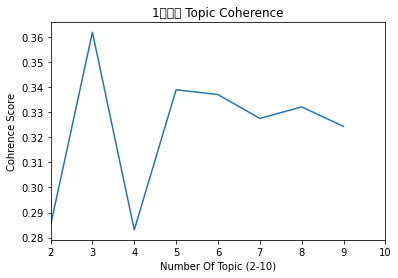

In [23]:
import matplotlib.pyplot as plt
import numpy

k=[]
for i in range(2,10):
    k.append(i)

x=numpy.array(k)
y=numpy.array(coherence_score)
title = f'{keyword} Topic Coherence'
plt.title(title)
plt.plot(x,y)
plt.xlim(2,10)
plt.xlabel('Number Of Topic (2-10)')
plt.ylabel('Cohrence Score')
plt.show()

In [27]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=3)
# model.print_topics()
model.print_topics(num_words=100) # num_topics=20

[(0,
  '0.024*"메뉴" + 0.018*"고기" + 0.015*"주문" + 0.010*"맛집" + 0.009*"갈비" + 0.009*"음식" + 0.009*"창업" + 0.007*"가족_외식" + 0.006*"진짜" + 0.006*"가격" + 0.006*"샐러드" + 0.005*"추천" + 0.005*"생각" + 0.005*"식사" + 0.005*"가족" + 0.005*"피자" + 0.005*"치킨" + 0.005*"추가" + 0.005*"준비" + 0.004*"세트" + 0.004*"반찬" + 0.004*"메인" + 0.004*"사람" + 0.004*"외식" + 0.004*"스테이크" + 0.003*"느낌" + 0.003*"해산물" + 0.003*"카페" + 0.003*"파스타" + 0.003*"채소" + 0.003*"라면" + 0.003*"시작" + 0.003*"커피" + 0.003*"새우" + 0.003*"국물" + 0.003*"한정식" + 0.003*"야채" + 0.003*"요리" + 0.002*"입맛" + 0.002*"주말" + 0.002*"참치" + 0.002*"예약" + 0.002*"사장" + 0.002*"참고" + 0.002*"자리" + 0.002*"할인" + 0.002*"편이" + 0.002*"불고기" + 0.002*"지출" + 0.002*"코스" + 0.002*"판매" + 0.002*"한우" + 0.002*"정식" + 0.002*"때문" + 0.002*"활용" + 0.002*"메뉴판" + 0.002*"제공" + 0.002*"후식" + 0.002*"신랑" + 0.002*"부담" + 0.002*"인테리어" + 0.002*"사용" + 0.002*"친구" + 0.002*"직원" + 0.002*"재료" + 0.002*"그릇" + 0.002*"한식" + 0.002*"장소" + 0.002*"대게" + 0.002*"가득" + 0.002*"기본" + 0.002*"전복" + 0.002*"직접" + 0.002*"외식_장소" + 0.002*"보통" + 0

In [ ]:
_topics = getTopics(model)

df = pd.DataFrame(_topics)

df.set_index(0)

save_to_csv("TM", keyword, word, co_top_df)